
Welcome to the Project Scheduling Tool!

You can choose to:
1. Perform CPM (Critical Path Method)
   - CSV Format: Task,Predecessors,Duration

2. Perform PERT (Program Evaluation Review Technique)
   - CSV Format: Task,Predecessors,Optimistic,MostLikely,Pessimistic

Predecessors should be listed as a string of capital letters (e.g., AB means A and B are predecessors).
Use '-' if the task has no predecessors.
    


Do you want to read from a CSV file or enter data manually? (csv/manual):  csv
Enter the path to the CSV file:  data1.csv



--- Task Attributes ---
  Name   DU    ES    EF    LF    LS   SK
0    A  5.0   0.0   5.0   5.0   0.0  0.0
1    B  3.0   5.0   8.0  17.0  14.0  9.0
2    C  6.0   5.0  11.0  11.0   5.0  0.0
3    D  2.0   8.0  10.0  19.0  17.0  9.0
4    E  4.0  11.0  15.0  15.0  11.0  0.0
5    F  7.0  11.0  18.0  19.0  12.0  1.0
6    G  1.0  18.0  19.0  20.0  19.0  1.0
7    H  5.0  15.0  20.0  20.0  15.0  0.0
8  End  0.0  20.0  20.0  20.0  20.0  0.0

--- Critical Path ---
A -> C -> E -> H -> End
Project Completion Time: 20.0


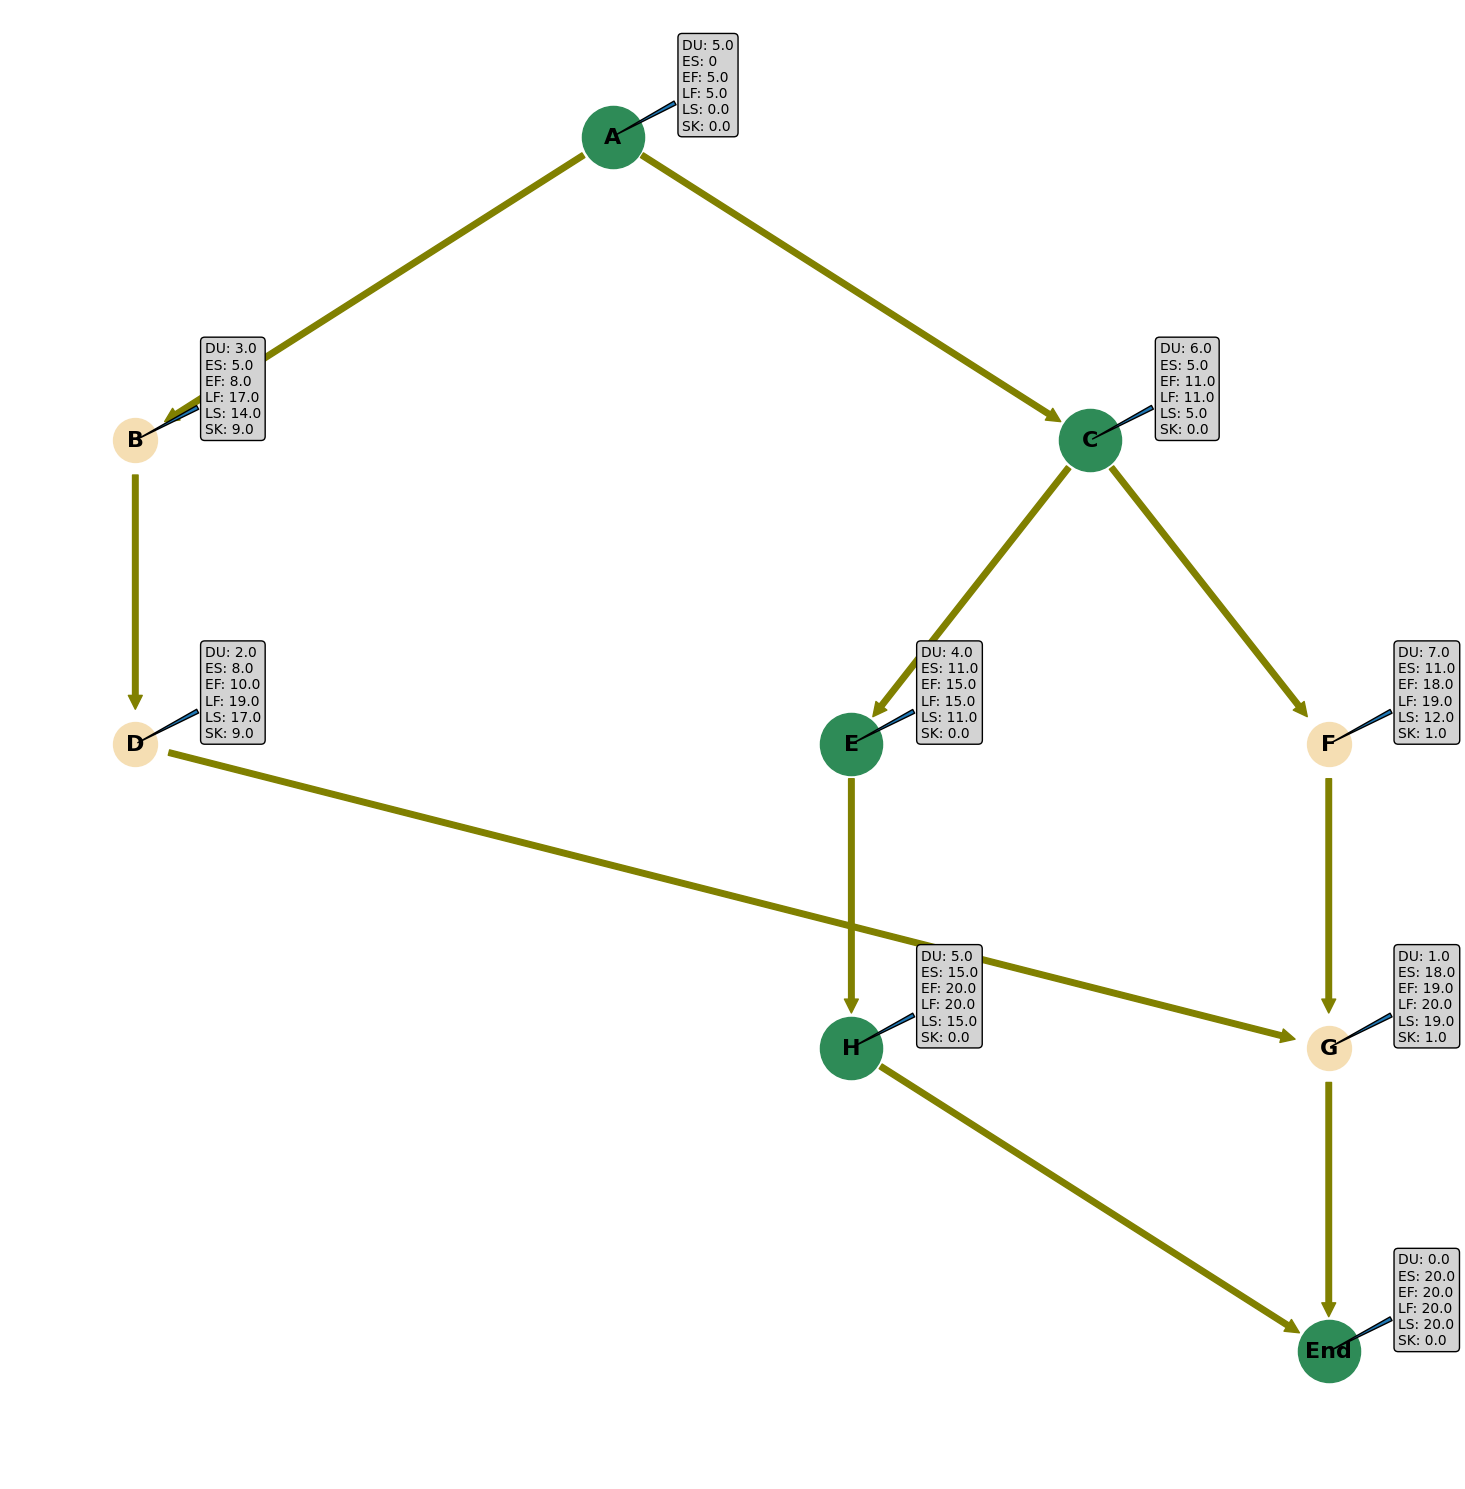

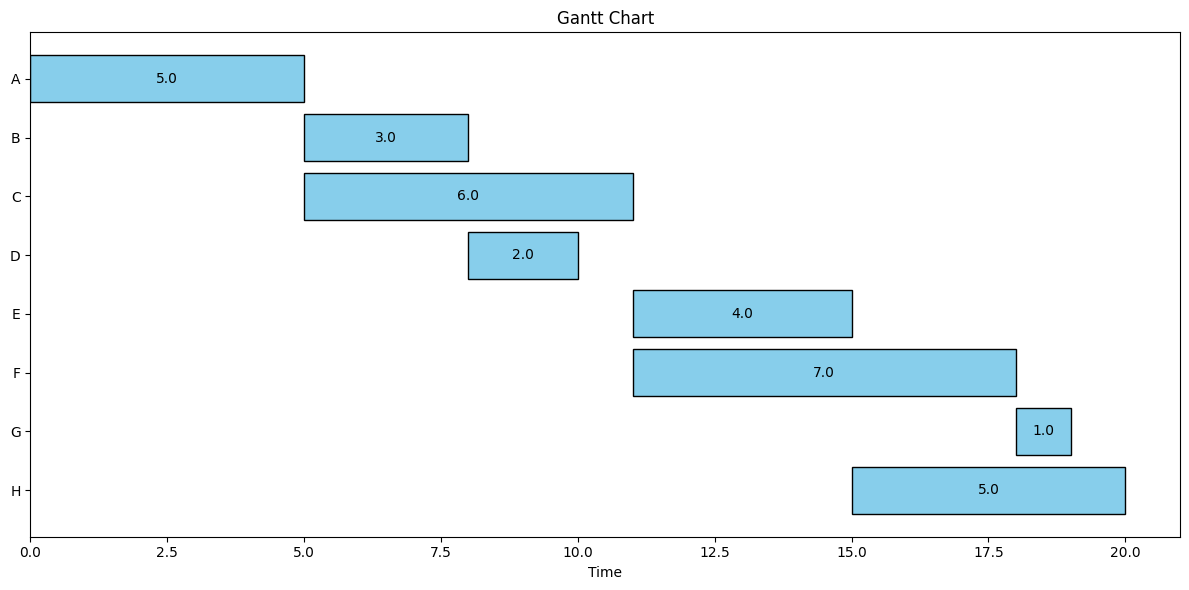

In [19]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import os

def compute_duration(row):
    if len(row) == 3:  # CPM format
        return float(row.iloc[2])
    return (float(row.iloc[3]) + 4 * float(row.iloc[2]) + float(row.iloc[4])) / 6  # PERT formula

def bfs_topological_order(start_nodes, graph):
    visited = [False] * len(graph)
    level = [None] * len(graph)
    queue = deque(start_nodes)
    for s in start_nodes:
        level[s] = 0
        visited[s] = True

    path = []
    while queue:
        s = queue.popleft()
        path.append(s)
        for neighbor in graph[s]:
            if not visited[neighbor]:
                queue.append(neighbor)
                level[neighbor] = level[s] + 1
                visited[neighbor] = True
            else:
                level[neighbor] = max(level[s] + 1, level[neighbor])
    return path, level

def without(d, keys={"Name"}):
    return {x: d[x] for x in d if x not in keys}

def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = {}
    def _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter, pos=None, parent=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        neighbors = list(G.successors(root))
        if parent is not None and parent in neighbors:
            neighbors.remove(parent)
        if neighbors:
            dx = width / len(neighbors)
            nextx = xcenter - width / 2 - dx / 2
            for neighbor in neighbors:
                nextx += dx
                pos = _hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap,
                                     vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def process_file(filepath):
    start_nodes = []
    graph = []
    atts = []
    new = []
    st = ""
    path = []

    data = pd.read_csv(filepath)
    last = chr(ord(data.iloc[-1, 0]) + 1)

    for deps in data.iloc[:, 1]:
        new.extend([ch for ch in deps if ch != '-'])

    for task in data.iloc[:, 0]:
        if task not in new:
            st += task

    if data.shape[1] == 3:  # CPM
        df = pd.DataFrame([[last, st, 0]], columns=["ac", "pr", "du"])
    else:  # PERT
        df = pd.DataFrame([[last, st, 0, 0, 0]], columns=["ac", "pr", "b", "m", "a"])
    data = pd.concat([data, df], ignore_index=True)

    for _ in range(len(data)):
        graph.append([])
        atts.append({})

    for i, row in data.iterrows():
        atts[i]["Name"] = row.iloc[0]
        if data.shape[1] == 5:  # PERT
            atts[i]["Optimistic"] = row.iloc[2]
            atts[i]["Most Probable"] = row.iloc[3]
            atts[i]["Pessimistic"] = row.iloc[4]
        atts[i]["DU"] = compute_duration(row)
        if row.iloc[1] == "-":
            start_nodes.append(i)
        else:
            for ch in row.iloc[1]:
                graph[ord(ch) - 65].append(i)

    path, level = bfs_topological_order(start_nodes, graph)
    path = [x for _, x in sorted(zip([level[p] for p in path], path))]

    for s in path:
        if data.iloc[s, 1] == "-":
            atts[s]["ES"] = 0
        else:
            es_candidates = [atts[ord(ch) - 65]["EF"] for ch in data.iloc[s, 1]]
            atts[s]["ES"] = max(es_candidates)
        atts[s]["EF"] = atts[s]["ES"] + atts[s]["DU"]

    for i in range(len(graph)):
        if not graph[i]:
            atts[i]["LF"] = atts[i]["EF"]
            atts[i]["LS"] = atts[i]["ES"]

    for i in reversed(path):
        if data.iloc[i, 1] != "-":
            for ch in data.iloc[i, 1]:
                idx = ord(ch) - 65
                if "LF" in atts[idx]:
                    atts[idx]["LF"] = min(atts[i]["LS"], atts[idx]["LF"])
                else:
                    atts[idx]["LF"] = atts[i]["LS"]
                atts[idx]["LS"] = atts[idx]["LF"] - atts[idx]["DU"]
        atts[i]["SK"] = atts[i]["LF"] - atts[i]["EF"]

    atts[-1]["Name"] = "End"

    # Convert the task attributes into a DataFrame
    df_task_attributes = pd.DataFrame(atts)

    print("\n--- Task Attributes ---")
    print(df_task_attributes)

    print("\n--- Critical Path ---")
    critical_path = [a["Name"] for a in atts if a["LF"] == a["EF"]]
    print(" -> ".join(critical_path))
    print(f"Project Completion Time: {atts[-1]['EF']}")

    # Graph Visualization
    G = nx.DiGraph()
    for i in range(len(graph)):
        for j in graph[i]:
            G.add_edge(atts[i]["Name"], atts[j]["Name"])

    node_attr = {att["Name"]: att for att in atts}
    nx.set_node_attributes(G, node_attr)

    fig, ax = plt.subplots(figsize=(15, 15))
    pos = hierarchy_pos(G, root="Start" if "Start" in G.nodes else atts[0]["Name"])

    critical_nodes = [n for n, d in node_attr.items() if d["LF"] == d["EF"]]
    non_critical_nodes = [n for n in G.nodes if n not in critical_nodes]

    nx.draw_networkx_edges(G, pos, edge_color='olive', width=1,
                           arrowstyle='simple', arrowsize=20,
                           min_source_margin=25, min_target_margin=25)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='seagreen',
                           nodelist=critical_nodes)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='wheat',
                           nodelist=non_critical_nodes)
    nx.draw_networkx_labels(G, pos, font_weight="bold", font_color="black", font_size=16)

    for node in G.nodes:
        xy = pos[node]
        d = without(G.nodes[node])
        text = '\n'.join(f'{k}: {v}' for k, v in d.items())
        ax.annotate(text, xy=xy, xytext=(50, 5), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="lightgrey"),
                    arrowprops=dict(arrowstyle="wedge"))

    ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Gantt Chart Visualization
    fig, gantt = plt.subplots(figsize=(12, 6))
    task_labels = [a["Name"] for a in atts if a["Name"] != "End"]
    start_times = [a["ES"] for a in atts if a["Name"] != "End"]
    durations = [a["DU"] for a in atts if a["Name"] != "End"]

    gantt.barh(task_labels, durations, left=start_times, color="skyblue", edgecolor="black")
    gantt.set_xlabel("Time")
    gantt.set_title("Gantt Chart")
    gantt.invert_yaxis()
    for i, (start, dur) in enumerate(zip(start_times, durations)):
        gantt.text(start + dur / 2, i, f"{dur:.1f}", ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()

def guide():
    print("""
Welcome to the Project Scheduling Tool!

You can choose to:
1. Perform CPM (Critical Path Method)
   - CSV Format: Task,Predecessors,Duration

2. Perform PERT (Program Evaluation Review Technique)
   - CSV Format: Task,Predecessors,Optimistic,MostLikely,Pessimistic

Predecessors should be listed as a string of capital letters (e.g., AB means A and B are predecessors).
Use '-' if the task has no predecessors.
    """)

def manual_input():
    choice = input("Choose method (CPM/PERT): ").strip().upper()
    n = int(input("Enter number of tasks: "))
    if choice == "CPM":
        cols = ["Task", "Predecessors", "Duration"]
    elif choice == "PERT":
        cols = ["Task", "Predecessors", "Optimistic", "MostLikely", "Pessimistic"]
    else:
        print("Invalid choice.")
        return

    rows = []
    print(f"Enter task details as: {', '.join(cols)}")
    for _ in range(n):
        row = input().split(',')
        rows.append(row)

    df = pd.DataFrame(rows, columns=cols)
    tmp_path = "_manual_input.csv"
    df.to_csv(tmp_path, index=False)
    process_file(tmp_path)
    os.remove(tmp_path)

if __name__ == '__main__':
    guide()
    mode = input("Do you want to read from a CSV file or enter data manually? (csv/manual): ").strip().lower()
    if mode == "csv":
        filename = input("Enter the path to the CSV file: ")
        if os.path.exists(filename):
            process_file(filename)
        else:
            print("File not found. Please check the path and try again.")
    elif mode == "manual":
        manual_input()
    else:
        print("Invalid option.")